Notebook by Samuel Chow, Callahan Hinckley, Jared Cohen, Varun Jain, Dennis Schimtzek, Will Robbins


## Notes and Key Assumptions

The only data file needed for this is the accepted_2007_to_2018Q4.csv which is provided by the professor. 

We assume that Lending Club's methodology of grading loans and determining interest rates does not change significantly over time. 

We assume that the loans are paid on a regular monthly basis and the term is as said. 

We also assume that when we calculate our expected return, the loans that default happen at the very beginning, so no money is made off of the defaulted loans. 

## Importing Libraries and Data

In [ ]:
pip install pandas

In [ ]:
pip install numpy

In [ ]:
pip install matplotlib

In [ ]:
pip install seaborn

In [ ]:
pip install sklearn

In [ ]:
pip install xgboost

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')


To make our entire process easier, we randomly sample 50% of the accepted data to use going forward. The smaller dataset will make it easier for us to do analysis and modeling since it won't take as much time, and we can use a random sample since we assumed that the process for grading loans does not change over time on Lending Club's behalf.

We also used 10% of the data from the other 50% as the suggestion data that we will use in the suggestions section far below. 

In [65]:
accepted = pd.read_csv("accepted_2007_to_2018Q4.csv")
accepted_sample = accepted.sample(frac=0.5, replace=False, random_state=1)
to_suggest = accepted.drop(accepted_sample.index).sample(frac=0.1)

accepted.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,...,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,...,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,NaN,NaN,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,...,218418.0,18696.0,6200.0,14877.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,076xx,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,NaN,NaN,13.0,0.0,7802.0,11.6,17.0,w,15897.65,15897.65,...,381215.0,52226.0,62500.0,18000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,major_purchase,Major purchase,174xx,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,NaN,12.0,0.0,21929.0,64.5,35.0,w,0.00,0.00,...,439570.0,95768.0,20300.0,88097.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## Cleaning Data

Cleaning up some of the data. Making term and emp_length columns into floats rather than strings. We are also only looking at the loans that are finished and fully paid off or have defaulted. We turned the fully paid off loans into 0's and the defaulted loans into 1's. We filter out all the other loans that are in progress. 

In [3]:
accepted['term'] = accepted['term'].str.replace(r'\D+', '').astype(float)
accepted['emp_length'] = accepted['emp_length'].str.replace(r'\D+', '').astype(float)


accepted.loc[accepted['loan_status'] == "Fully Paid", 'loan_status'] = 0
accepted.loc[accepted['loan_status'] == "Does not meet the credit policy. Status:Fully Paid", 'loan_status'] = 0
accepted.loc[accepted['loan_status'] == "Charged Off", 'loan_status'] = 1
accepted.loc[accepted['loan_status'] == "Default", 'loan_status'] = 1
accepted.loc[accepted['loan_status'] == "Does not meet the credit policy. Status:Charged Off", 'loan_status'] = 1


accepted = accepted[(accepted.loan_status == 0) | (accepted.loan_status == 1)]

## Data Exploration

Important Note: 0 = Fully Paid and 1 = Not Fully Paid

In [4]:
accepted['loan_status'].value_counts(normalize=True) * 100


0    78.973689
1    21.026311
Name: loan_status, dtype: float64

In [5]:
accepted['term'].value_counts(normalize=True) * 100

36.0    75.748285
60.0    24.251715
Name: term, dtype: float64

Looking at the distribution of loans by grade. B and C graded loans are the most common and F and G are the least. Also looking at the number of each grade in our dataset. This is important to see the grades that Lending Club actually gives and how common they are. 

In [6]:
accepted['grade'].value_counts(normalize=True) * 100


C    28.400358
B    28.393928
A    19.027938
D    14.214042
E     7.175737
F     2.122743
G     0.665254
Name: grade, dtype: float64

In [7]:
pd.DataFrame(accepted.groupby(['loan_status','grade']).size())

0
loan_status grade        
0           A       88905
            B      121553
            C      108078
            D       47159
            E       20626
            F        5215
            G        1520
1           A        5798
            B       19765
            C       33272
            D       23585
            E       15088
            F        5350
            G        1791

We see a clear correlation between interest rate and grade. Since both of these are Lending Club's own creations, we will not use these features in our model, but it is good to see that there is a strong correlation between the two. 

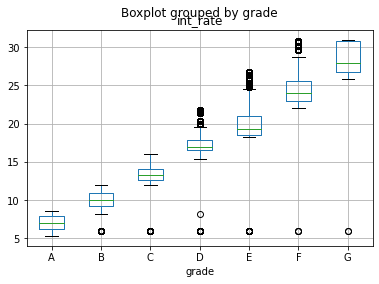

In [8]:
accepted.boxplot(column = 'int_rate', by = 'grade')

Ovreall, loans that default have higher interest rates by about 2.5%. 

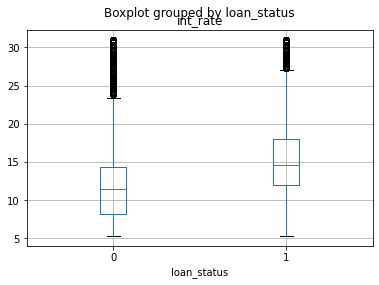

In [9]:
accepted.boxplot(column = 'int_rate', by = 'loan_status')

The distribution of installment amounts for loans that do and do not default look very similar in their shape. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f2b25b1d0>]],
      dtype=object)

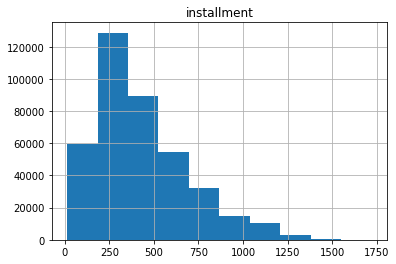

In [10]:
accepted[accepted['loan_status'] == 0].hist('installment')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f32ddbcd0>]],
      dtype=object)

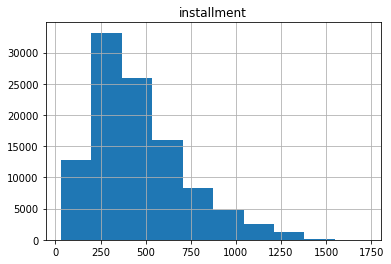

In [11]:
accepted[accepted['loan_status'] == 1].hist('installment')

Higher fico scores tend to have a lesser chance of defaulting, but the difference isn't that significant. 

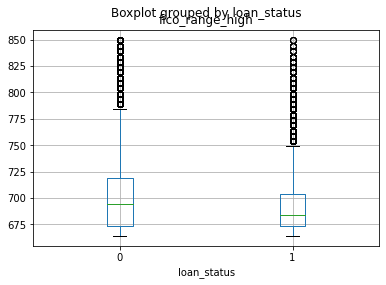

In [12]:
accepted.boxplot(column = 'fico_range_high', by = 'loan_status')

Visualization of Loan Status: Of loans that were accepted and are not currently in progress, roughly 4 out of every 5 were fully paid. 

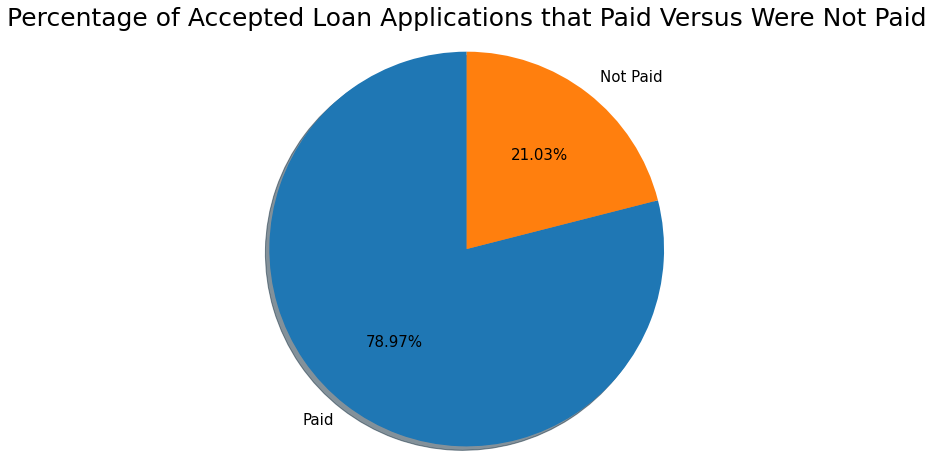

In [13]:
labels = 'Paid', 'Not Paid'
sizes = [accepted.loan_status[accepted['loan_status']==0].count(), accepted.loan_status[accepted['loan_status']==1].count()]
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes,labels=labels,  autopct='%1.2f%%', textprops={'fontsize': 15},
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Percentage of Accepted Loan Applications that Paid Versus Were Not Paid", size = 25)
plt.rcParams['font.size'] = 20
plt.show()

Term: Loan lengths are either 36 or 60 months in length 

In [14]:
print(accepted['term'].value_counts())

36.0    377003
60.0    120702
Name: term, dtype: int64


Loans with a 60-month term have a higher average interest rate than 36-month term loans

In [15]:
accepted.groupby("term").agg(np.mean)["int_rate"]

term
36.0    11.512941
60.0    16.069164
Name: int_rate, dtype: float64

There is a moderate correlation of 0.42 between loan term and interest rate.

In [16]:
accepted['term'].corr(accepted['int_rate'])

0.4209470082780961

Paid loans(0) are lower in amount than not paid loans (1)

Text(0.5, 0.98, '')

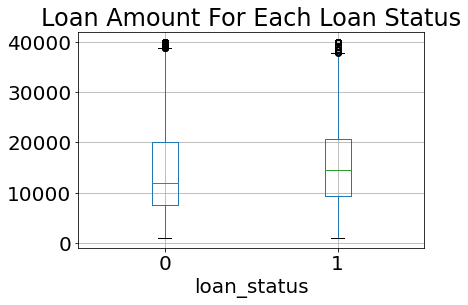

In [17]:
accepted.boxplot(column = 'loan_amnt', by = 'loan_status')
plt.title("Loan Amount For Each Loan Status")
plt.suptitle("")

We noticed that the amounts of Loan Amount, Funded Amount, and Funded Amount by Investors are identical in the head above. If they are the same then we can remove them and leave just one variable. After comparing these features we found that they are not all the same. 

Text(0.5, 0.98, '')

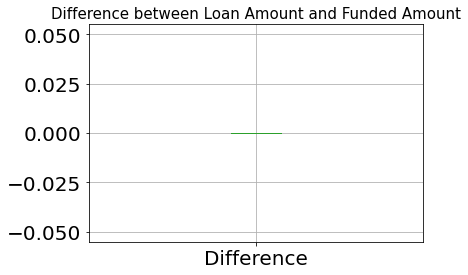

In [18]:
#Comparing Loan Amount and Funded Amount 
#accepted_high_corr['loan_amnt'].equals(accepted_high_corr['funded_amnt'])
  #False
comp1 = accepted[['loan_amnt','funded_amnt']]
comp1['Equals']= accepted['loan_amnt'] == accepted['funded_amnt']
comp1.Equals.value_counts()
comp1['Difference'] = accepted['loan_amnt'] - accepted['funded_amnt']
comp1.boxplot(column = 'Difference', by=None)
plt.title("Difference between Loan Amount and Funded Amount", fontsize=15)
plt.suptitle("")

Text(0.5, 0.98, '')

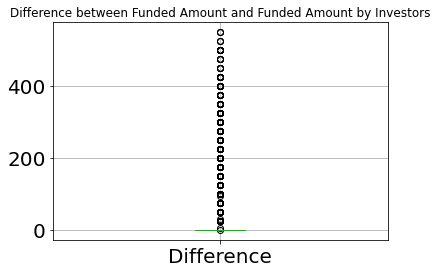

In [19]:
#Comparing Funded Amount and Funded Amount by Investors
comp2 = accepted[['funded_amnt', 'funded_amnt_inv']]
comp2['Equals']= accepted['funded_amnt_inv'] == accepted['funded_amnt']
comp2.Equals.value_counts()
comp2['Difference'] = accepted['funded_amnt'] - accepted['funded_amnt_inv']
comp2.boxplot(column = 'Difference', by=None)
plt.title("Difference between Funded Amount and Funded Amount by Investors", fontsize=12)
plt.suptitle("")

We compare Loan Status and the numeric features that could potentially be different between paid loans and loans that were not paid to help us identify what features may or may not be important and identify any interesting trends. 

Loans that were paid seem to be slightly lower in their loan amounts. 
Loans that were paid tend to also have lower interest rates than those that were not paid.
DTI Joint appears to have slightly different values for paid loans and loans not paid. 

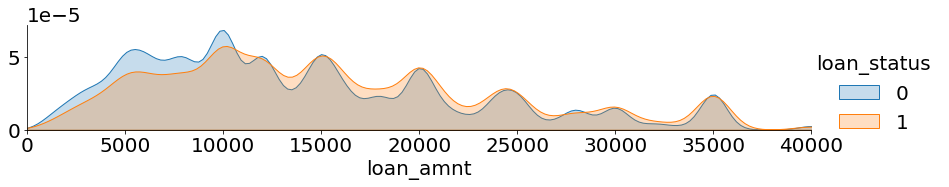

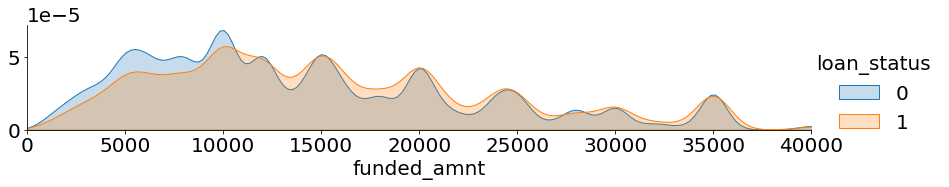

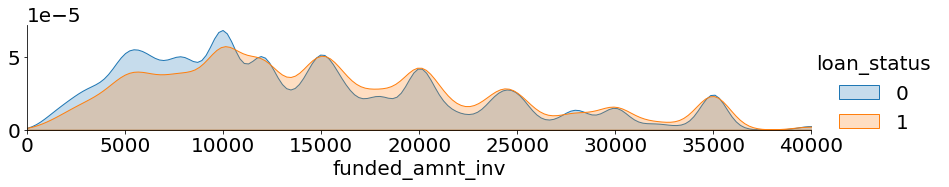

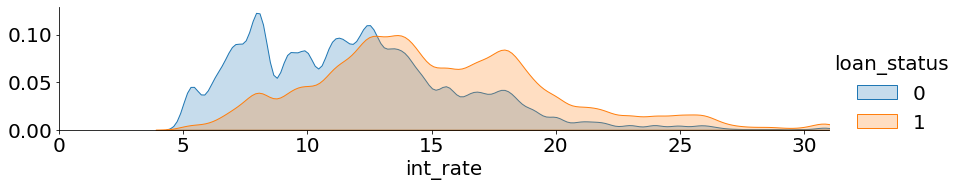

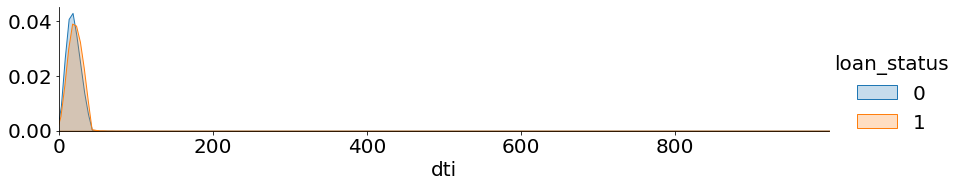

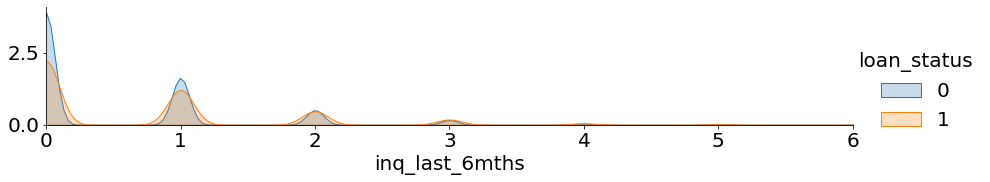

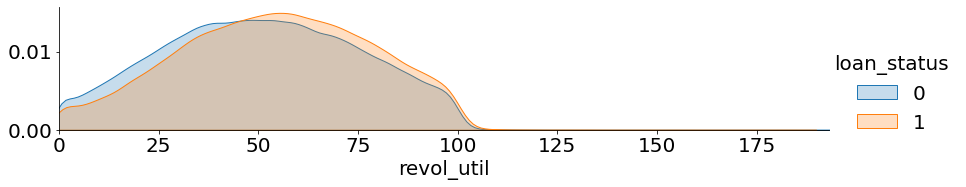

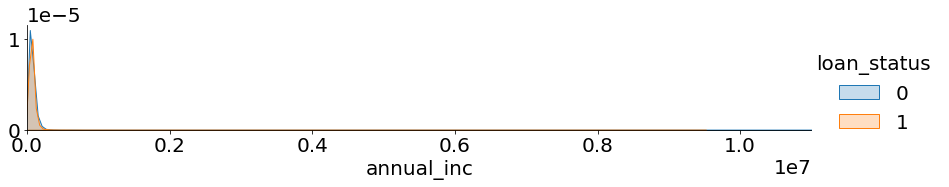

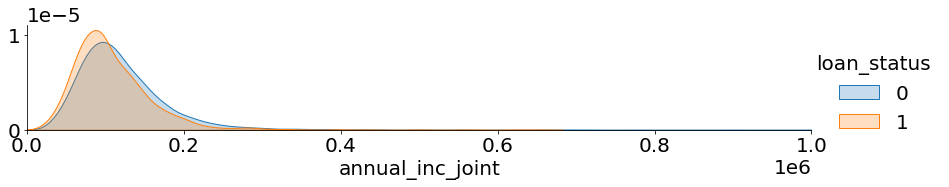

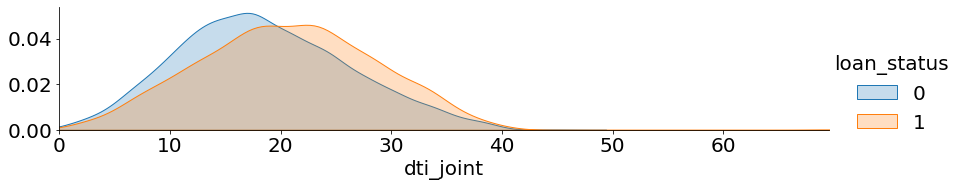

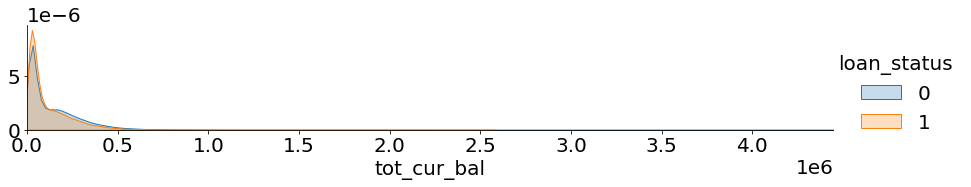

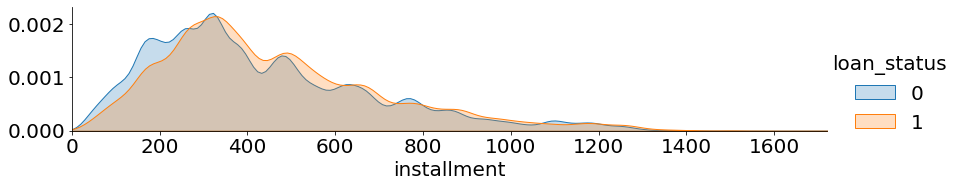

In [20]:
select_numeric_features = accepted[['loan_amnt','funded_amnt','funded_amnt_inv','int_rate','dti','inq_last_6mths','revol_util','annual_inc','annual_inc_joint','dti_joint','tot_cur_bal','installment']]
for col in select_numeric_features:
    facet = sns.FacetGrid(accepted, hue="loan_status",aspect=4)
    facet.map(sns.kdeplot,col,shade= True)
    facet.set(xlim=(0, accepted[col].max()))
    facet.add_legend()
    plt.show()
    

## Feature Engineering

We do some feature engineering here. We turned grade and subgrade into ordinal numbers (0, 1, 2, etc). Now, grade A is turned into a 0, grade B is a 1 and so forth. We also one hot encoded some of the categorical features that don't have a specific order such as home ownership, purpose, and application. 

In [21]:
accepted_encoded = accepted
encoder = LabelEncoder()
accepted_encoded['grade'] = encoder.fit_transform(accepted_encoded['grade'])
accepted_encoded['sub_grade'] = encoder.fit_transform(accepted_encoded['sub_grade'])

home_ownership_ohc = pd.get_dummies(accepted_encoded['home_ownership'])
purpose_ohc = pd.get_dummies(accepted_encoded['purpose'])
verification_status_ohc = pd.get_dummies(accepted_encoded['verification_status'])
disbursement_method_ohc = pd.get_dummies(accepted_encoded['disbursement_method'])
application_type_ohc = pd.get_dummies(accepted_encoded['application_type'])

accepted_encoded = pd.concat([accepted_encoded, home_ownership_ohc, purpose_ohc, verification_status_ohc, disbursement_method_ohc, application_type_ohc], axis=1)
accepted_encoded = accepted_encoded.drop(columns=['home_ownership', 'purpose', 'verification_status', 'disbursement_method', 'application_type'])

In [22]:
original_columns = ['loan_status', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'annual_inc', 
                 'title', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 
                 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'open_acc_6m', 
                 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
                 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 
                 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
                 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
                 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 
                 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies',
                 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'revol_bal_joint',
                 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
                 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'ANY', 'MORTGAGE', 'NONE',
                  'OWN', 'RENT', 'car', 'credit_card', 'debt_consolidation', 'educational', 'home_improvement', 'house', 'major_purchase', 'medical',
                 'moving', 'other', 'renewable_energy', 'small_business', 'vacation', 'wedding', 'Not Verified', 'Source Verified', 'Verified', 'Cash',
                 'DirectPay', 'Individual', 'Joint App']

In [23]:
accepted_encoded['loan_status'] = accepted_encoded['loan_status'].astype('int')


Looking at correlation between each of the columns

In [24]:
column_corr = accepted_encoded[original_columns].corr()

In [25]:
column_corr

,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,annual_inc_joint,dti_joint,acc_now_delinq,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,...,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,ANY,MORTGAGE,NONE,OWN,RENT,car,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,Not Verified,Source Verified,Verified,Cash,DirectPay,Individual,Joint App
loan_status,1.000000,0.065567,0.065567,0.065484,0.205597,0.290580,0.045574,0.287667,0.293596,-0.016578,-0.041517,0.085628,0.017557,-0.131307,-0.131306,0.084323,-0.009725,0.022735,0.031508,0.024585,-0.025021,0.057767,-0.002277,-0.096095,0.122409,0.003856,0.056360,0.009221,0.035880,0.034175,-0.019010,-0.002803,0.043627,0.061595,0.077979,-0.037588,0.086325,-0.058079,0.034177,-0.018283,...,0.005735,-0.081597,-0.003335,-0.077974,0.000785,0.003655,-0.249432,-0.249432,0.148314,-0.132562,-0.004117,0.142944,0.020950,-0.038019,-0.000620,-0.071732,-0.000731,0.003874,0.070661,-0.011390,-0.044370,0.040043,-0.000731,-0.015892,0.004934,-0.002723,0.004325,0.006776,0.004541,0.003795,0.022975,-0.004245,-0.000371,-0.087036,0.009535,0.075884,-0.003978,0.003978,-0.018437,0.018437
loan_amnt,0.065567,1.000000,1.000000,0.999995,0.376932,0.129191,0.952293,0.127447,0.131313,0.082688,0.298120,0.018016,-0.010400,0.118760,0.118759,-0.025745,-0.023195,0.004296,0.182904,-0.074625,0.320251,0.110945,0.204630,0.365418,0.067189,0.000235,-0.016415,0.025170,-0.000757,0.027618,-0.015782,0.144802,-0.086049,-0.033986,-0.019048,0.361426,-0.001118,0.327243,0.000905,0.069051,...,0.004054,0.339185,0.278213,0.383919,0.201144,0.380802,0.192973,0.192973,-0.054522,0.167682,0.218927,0.026340,0.056157,0.187393,0.000071,0.171057,-0.000746,-0.016137,-0.164033,-0.057580,0.036193,0.089687,-0.002013,-0.009590,0.004167,-0.035276,-0.068620,-0.061726,-0.125688,-0.014178,0.011052,-0.079353,-0.002810,-0.170580,0.037272,0.128391,-0.000503,0.000503,-0.063716,0.063716
funded_amnt,0.065567,1.000000,1.000000,0.999995,0.376932,0.129191,0.952293,0.127447,0.131313,0.082688,0.298120,0.018016,-0.010400,0.118760,0.118759,-0.025745,-0.023195,0.004296,0.182904,-0.074625,0.320251,0.110945,0.204630,0.365418,0.067189,0.000235,-0.016415,0.025170,-0.000757,0.027618,-0.015782,0.144802,-0.086049,-0.033986,-0.019048,0.361426,-0.001118,0.327243,0.000905,0.069051,...,0.004054,0.339185,0.278213,0.383919,0.201144,0.380802,0.192973,0.192973,-0.054522,0.167682,0.218927,0.026340,0.056157,0.187393,0.000071,0.171057,-0.000746,-0.016137,-0.164033,-0.057580,0.036193,0.089687,-0.002013,-0.009590,0.004167,-0.035276,-0.068620,-0.061726,-0.125688,-0.014178,0.011052,-0.079353,-0.002810,-0.170580,0.037272,0.128391,-0.000503,0.000503,-0.063716,0.063716
funded_amnt_inv,0.065484,0.999995,0.999995,1.000000,0.376913,0.129003,0.952260,0.127215,0.131093,0.082707,0.298170,0.017923,-0.010432,0.118939,0.118938,-0.025795,-0.023152,0.004387,0.182890,-0.074632,0.320253,0.110850,0.204636,0.365449,0.067175,0.000215,-0.016437,0.025158,-0.000758,0.027608,-0.015780,0.144804,-0.086057,-0.034031,-0.019103,0.361445,-0.001139,0.327301,0.000904,0.069046,...,0.004034,0.339238,0.278208,0.384012,0.201142,0.380814,0.192925,0.192925,-0.054531,0.167670,0.218946,0.026381,0.056195,0.187407,0.000074,0.171079,-0.000745,-0.016144,-0.164051,-0.057584,0.036214,0.089658,-0.002012,-0.009590,0.004155,-0.035287,-0.068609,-0.061711,-0.125660,-0.014171,0.011053,-0.079358,-0.0

Looking at the columns that have a correlation of greater than absolute value of 0.05 to loan status. We want to most likely keep these columns becuase they will be the strongest predictor of loan status. 

In [26]:
column_corr[abs(column_corr['loan_status']) > 0.05]['loan_status']

loan_status                1.000000
loan_amnt                  0.065567
funded_amnt                0.065567
funded_amnt_inv            0.065484
term                       0.205597
int_rate                   0.290580
grade                      0.287667
sub_grade                  0.293596
dti                        0.085628
fico_range_low            -0.131307
fico_range_high           -0.131306
inq_last_6mths             0.084323
revol_util                 0.057767
annual_inc_joint          -0.096095
dti_joint                  0.122409
open_acc_6m                0.056360
open_rv_12m                0.061595
open_rv_24m                0.077979
all_util                   0.086325
total_rev_hi_lim          -0.058079
inq_last_12m               0.056729
acc_open_past_24mths       0.111301
avg_cur_bal               -0.081800
bc_open_to_buy            -0.087131
bc_util                    0.067097
mo_sin_old_rev_tl_op      -0.056061
mo_sin_rcnt_rev_tl_op     -0.058422
mo_sin_rcnt_tl            -0

When selecting the columns we wanted to use, we removed any columns that would be cause for leakage such as most recent fico scores or late payments. 

In [27]:
high_corr_columns = accepted_encoded[['loan_status', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'dti', 'fico_range_low', 
                     'fico_range_high', 'inq_last_6mths', 'revol_util', 'annual_inc_joint', 'dti_joint', 'open_acc_6m', 'open_rv_12m', 'open_rv_24m', 'all_util', 
                     'total_rev_hi_lim', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 
                     'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'num_tl_op_past_12m', 'percent_bc_gt_75', 
                     'tot_hi_cred_lim', 'total_bc_limit', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_revol_util', 
                     'MORTGAGE', 'RENT', 'Not Verified', 'Verified', 'annual_inc']]

Seeing if there are any NAs in the columns that we selected so that we can do data imputation. 

In [28]:
high_corr_columns.isna().any()

loan_status                False
loan_amnt                  False
funded_amnt                False
funded_amnt_inv            False
term                       False
int_rate                   False
installment                False
grade                      False
sub_grade                  False
dti                         True
fico_range_low             False
fico_range_high            False
inq_last_6mths             False
revol_util                  True
annual_inc_joint            True
dti_joint                   True
open_acc_6m                 True
open_rv_12m                 True
open_rv_24m                 True
all_util                    True
total_rev_hi_lim           False
inq_last_12m                True
acc_open_past_24mths       False
avg_cur_bal                 True
bc_open_to_buy              True
bc_util                     True
mo_sin_rcnt_rev_tl_op      False
mo_sin_rcnt_tl             False
mort_acc                   False
mths_since_recent_bc        True
mths_since

We filled in the secondary applicant columns with NAs with just the values from the primary applicant. For months since columns, we assumed NAs to mean that they haven't had that incident, so we filled those in with the max value from the entire column. Most of the other columns we just filled in with 0 because that is what we thought would make the most sense. 

In [29]:
high_corr_columns['dti'] = high_corr_columns['dti'].fillna(value=high_corr_columns['dti'].mean())
high_corr_columns['inq_last_6mths'] = high_corr_columns['inq_last_6mths'].fillna(0)
high_corr_columns['revol_util'] = high_corr_columns['revol_util'].fillna(0)
high_corr_columns['annual_inc_joint'] = high_corr_columns['annual_inc_joint'].fillna(high_corr_columns['annual_inc'])
high_corr_columns['dti_joint'] = high_corr_columns['dti_joint'].fillna(high_corr_columns['dti'])
high_corr_columns['open_acc_6m'] = high_corr_columns['open_acc_6m'].fillna(0)
high_corr_columns['open_rv_12m'] = high_corr_columns['open_rv_24m'].fillna(0)
high_corr_columns['open_rv_24m'] = high_corr_columns['open_rv_24m'].fillna(0)
high_corr_columns['all_util'] = high_corr_columns['all_util'].fillna(0)
high_corr_columns['total_rev_hi_lim'] = high_corr_columns['total_rev_hi_lim'].fillna(0)
high_corr_columns['inq_last_12m'] = high_corr_columns['inq_last_12m'].fillna(0)
high_corr_columns['acc_open_past_24mths'] = high_corr_columns['acc_open_past_24mths'].fillna(0)
high_corr_columns['avg_cur_bal'] = high_corr_columns['avg_cur_bal'].fillna(0)
high_corr_columns['bc_open_to_buy'] = high_corr_columns['bc_open_to_buy'].fillna(0)
high_corr_columns['bc_util'] = high_corr_columns['bc_util'].fillna(0)
high_corr_columns['mo_sin_rcnt_rev_tl_op'] = high_corr_columns['mo_sin_rcnt_rev_tl_op'].fillna(high_corr_columns['mo_sin_rcnt_rev_tl_op'].max())
high_corr_columns['mo_sin_rcnt_tl'] = high_corr_columns['mo_sin_rcnt_tl'].fillna(high_corr_columns['mo_sin_rcnt_tl'].max())
high_corr_columns['mort_acc'] = high_corr_columns['mort_acc'].fillna(0)
high_corr_columns['mths_since_recent_bc'] = high_corr_columns['mths_since_recent_bc'].fillna(high_corr_columns['mths_since_recent_bc'].max())
high_corr_columns['mths_since_recent_inq'] = high_corr_columns['mths_since_recent_inq'].fillna(high_corr_columns['mths_since_recent_inq'].max())
high_corr_columns['num_actv_rev_tl'] = high_corr_columns['num_actv_rev_tl'].fillna(0)
high_corr_columns['num_rev_tl_bal_gt_0'] = high_corr_columns['num_rev_tl_bal_gt_0'].fillna(0)
high_corr_columns['num_tl_op_past_12m'] = high_corr_columns['num_tl_op_past_12m'].fillna(0)
high_corr_columns['percent_bc_gt_75'] = high_corr_columns['percent_bc_gt_75'].fillna(0)
high_corr_columns['tot_hi_cred_lim'] = high_corr_columns['tot_hi_cred_lim'].fillna(0)
high_corr_columns['total_bc_limit'] = high_corr_columns['total_bc_limit'].fillna(0)
high_corr_columns['sec_app_fico_range_low'] = high_corr_columns['sec_app_fico_range_low'].fillna(high_corr_columns['fico_range_low'])
high_corr_columns['sec_app_fico_range_high'] = high_corr_columns['sec_app_fico_range_high'].fillna(high_corr_columns['fico_range_high'])
high_corr_columns['sec_app_inq_last_6mths'] = high_corr_columns['sec_app_inq_last_6mths'].fillna(high_corr_columns['inq_last_6mths'])
high_corr_columns['sec_app_mort_acc'] = high_corr_columns['sec_app_mort_acc'].fillna(high_corr_columns['mort_acc'])
high_corr_columns['sec_app_revol_util'] = high_corr_columns['sec_app_revol_util'].fillna(high_corr_columns['revol_util'])
high_corr_columns['annual_inc'] = high_corr_columns['annual_inc'].fillna(0)
high_corr_columns['annual_inc_joint'] = high_corr_columns['annual_inc_joint'].fillna(high_corr_columns['annual_inc'])

## Train Test Split

We split our dataset before modeling. 75% of our set will be used for training and 25% of it will be used for testing. We also got rid of columns that were influenced by Lending Club since we wanted our analysis to be unique. These columns included interest rate, grade, sub grade, and installment. When running our models, we found that including the columns did not increase the performance, so we just opted to drop them. 

In [30]:
X = high_corr_columns.drop(['loan_status'], axis=1)
y = high_corr_columns['loan_status'].astype(int)
X_train_with_lc, X_test_with_lc, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

X_train = X_train_with_lc.drop(['int_rate', 'grade', 'sub_grade', 'installment'], axis=1)
X_test = X_test_with_lc.drop(['int_rate', 'grade', 'sub_grade', 'installment'], axis=1)


### Feature Scaling

#### Normalization

We created another dataframe with normalized values for each of the columns and compared the model results for raw data and normalized data. 

In [31]:
from sklearn.preprocessing import MinMaxScaler

accepted_norm = MinMaxScaler().fit(X_train)
X_train_norm = pd.DataFrame(accepted_norm.transform(X_train))
X_test_norm = pd.DataFrame(accepted_norm.transform(X_test))

X_train_norm.columns = X_train.columns

X_test_norm.columns = X_train.columns

### Modeling

For our metrics, we will primarily be using AUROC. Because we are using an imbalanced dataset, using accuracy doesn't make the most sense. Analyzing the ROC is much better since it takes into consideration both precision and recall and the dataset imbalance. 

### Logistic Regression

First attempt at a basic logistic regression with our desired features. 

In [32]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

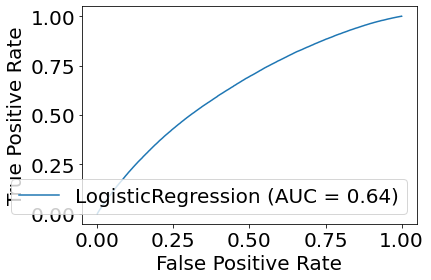

In [33]:
metrics.plot_roc_curve(lr, X_train, y_train)  
plt.show()                      

In [34]:
y_pred = lr.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[98483    12]
 [25925     7]]
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     98495
           1       0.37      0.00      0.00     25932

    accuracy                           0.79    124427
   macro avg       0.58      0.50      0.44    124427
weighted avg       0.70      0.79      0.70    124427



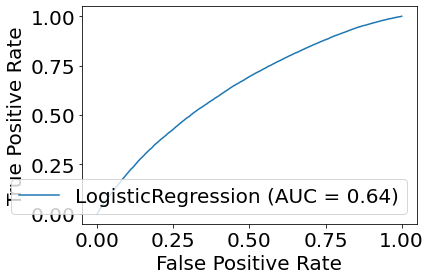

In [35]:
metrics.plot_roc_curve(lr, X_test, y_test)  
plt.show()                      

The ROC of the train data was 0.64 while the test data was 0.63. This is a good initial baseline result. 

Attempting to fit a logistic regression model with the normalized data. 

In [36]:
lr_norm = LogisticRegression()
lr_norm.fit(X_train_norm, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

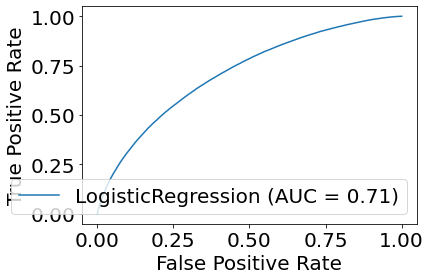

In [37]:
metrics.plot_roc_curve(lr_norm, X_train_norm, y_train)  
plt.show()                      

In [38]:
y_pred_norm = lr_norm.predict(X_test_norm)
print(confusion_matrix(y_test, y_pred_norm))
print(classification_report(y_test, y_pred_norm))

[[96298  2197]
 [23125  2807]]
              precision    recall  f1-score   support

           0       0.81      0.98      0.88     98495
           1       0.56      0.11      0.18     25932

    accuracy                           0.80    124427
   macro avg       0.68      0.54      0.53    124427
weighted avg       0.76      0.80      0.74    124427



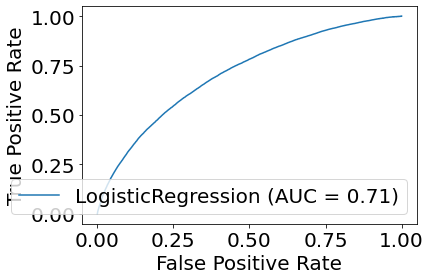

In [39]:
metrics.plot_roc_curve(lr_norm, X_test_norm, y_test)  
plt.show()                      

The normalized training data from the logistic regression has an ROC of 0.71 and it is the same for the testing data. This is good because we don't see any overfitting. Normalizing the data seems to be useful in logistic regression. 

### Random Forest

Next, we will try a random forest. We only use the raw data because using normalized data has no effect on tree based models. 

In [40]:
rf = RandomForestClassifier(random_state=1)

In [41]:
rf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

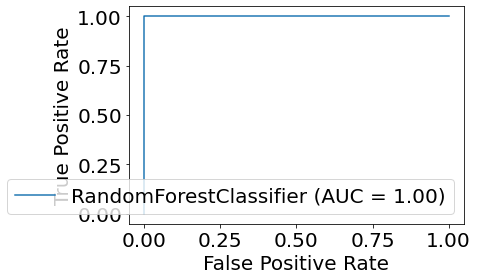

In [42]:
metrics.plot_roc_curve(rf, X_train, y_train)  
plt.show()                      

In [43]:
y_pred_rf = rf.predict(X_test)
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

[[96253  2242]
 [23142  2790]]
              precision    recall  f1-score   support

           0       0.81      0.98      0.88     98495
           1       0.55      0.11      0.18     25932

    accuracy                           0.80    124427
   macro avg       0.68      0.54      0.53    124427
weighted avg       0.75      0.80      0.74    124427



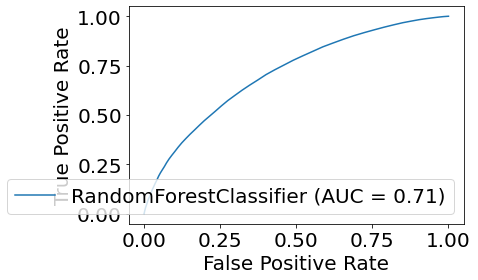

In [44]:
metrics.plot_roc_curve(rf, X_test, y_test)  
plt.show()                      

The train data has an AUROC of 1.00 which is perfect. There is worry of overfitting with the random forest model. Our testing data resulted in an ROC of .71, indicating that the random forest does in fact overfit. We will try tuning the model to see if we can prevent this. 

#### Tuning

We attempted many variations of tuning the random forest, but because we have so much data and the gridsearchCV function took many hours to run, we just included the most basic tuning with the best results. 

In [45]:
rf_tuned = RandomForestClassifier(random_state=1, n_estimators = 300, min_samples_leaf = 2)

In [47]:
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

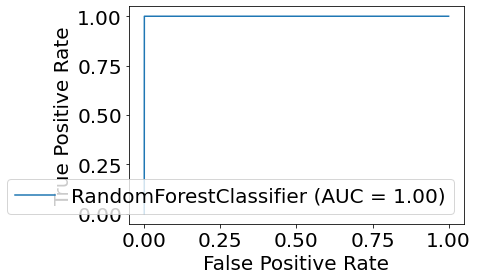

In [48]:
metrics.plot_roc_curve(rf_tuned, X_train, y_train)  
plt.show()                      

In [49]:
y_pred_rf_tuned = rf_tuned.predict(X_test)
print(confusion_matrix(y_test, y_pred_rf_tuned))
print(classification_report(y_test, y_pred_rf_tuned))

[[96463  2032]
 [23232  2700]]
              precision    recall  f1-score   support

           0       0.81      0.98      0.88     98495
           1       0.57      0.10      0.18     25932

    accuracy                           0.80    124427
   macro avg       0.69      0.54      0.53    124427
weighted avg       0.76      0.80      0.74    124427



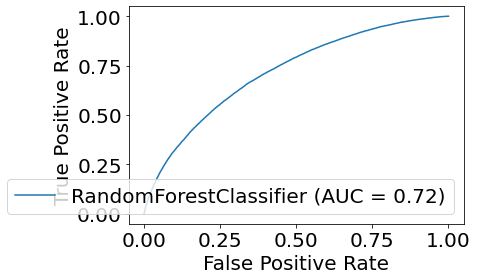

In [50]:
metrics.plot_roc_curve(rf_tuned, X_test, y_test)  
plt.show()                      

The random forest model is still overfitting as seen by the 1.00 train ROC compared to the 0.72 test ROC. Not entirely sure how to solve for this. Even after doing 5 and 10 fold cross-validation, the ROC for the test data did not change significantly. 

XGBoost

Finally, we attempted an XGBoost model. 

In [51]:
xgb = XGBClassifier(learning_rate = 0.1)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

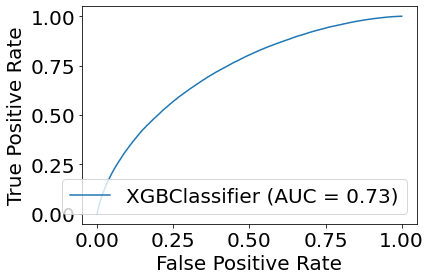

In [52]:
metrics.plot_roc_curve(xgb, X_train, y_train)  
plt.show()                      

In [53]:
y_pred_xgb = xgb.predict(X_test)
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

[[96538  1957]
 [23178  2754]]
              precision    recall  f1-score   support

           0       0.81      0.98      0.88     98495
           1       0.58      0.11      0.18     25932

    accuracy                           0.80    124427
   macro avg       0.70      0.54      0.53    124427
weighted avg       0.76      0.80      0.74    124427



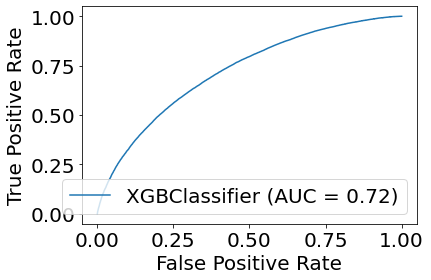

In [54]:
metrics.plot_roc_curve(xgb, X_test, y_test)  
plt.show()                    

The training ROC for the XGBoost model was 0.73 for the training and 0.72 for the testing ROC. This means there is little overfitting which is great. We will try to tune the XGBoost model a bit more below. 

Tuning

Similar to the random forest tuning, we only included the best version of our model tune. Going through all the combinations that we tried and wrapping the parameters into a gridsearchCV function takes too long to run. 

In [55]:
xgb_tuned = XGBClassifier(
  learning_rate = 0.1,
  subsample=0.8,
  colsample_bytree=0.8,
  objective= 'binary:logistic',
  scoring = 'roc_auc', 
  cv = 5,
  random_state=1
)

In [56]:
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, cv=5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, scoring='roc_auc',
              seed=None, silent=None, subsample=0.8, verbosity=1)

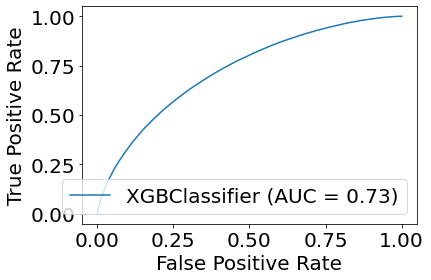

In [57]:
metrics.plot_roc_curve(xgb_tuned, X_train, y_train)  
plt.show()                      

In [58]:
y_pred_xgb_tuned = xgb_tuned.predict(X_test)
print(confusion_matrix(y_test, y_pred_xgb_tuned))
print(classification_report(y_test, y_pred_xgb_tuned))

[[96458  2037]
 [23115  2817]]
              precision    recall  f1-score   support

           0       0.81      0.98      0.88     98495
           1       0.58      0.11      0.18     25932

    accuracy                           0.80    124427
   macro avg       0.69      0.54      0.53    124427
weighted avg       0.76      0.80      0.74    124427



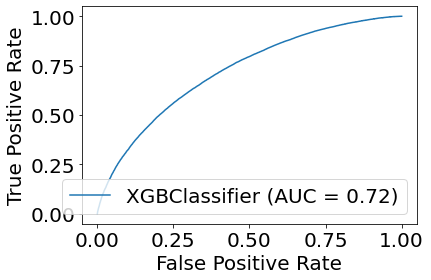

In [59]:
metrics.plot_roc_curve(xgb, X_test, y_test)  
plt.show()

The ROC was once again 0.73 and 0.72 both the training and testing data, respectively. The XGBoost is our best performing model, so we will used this tuned XGBoost model going forward. 

In [60]:
xgb_tuned_feature = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb_tuned.feature_importances_})
xgb_tuned_feature['Adjusted Importance'] = xgb_tuned_feature['Importance'] / max(xgb_tuned_feature['Importance'])
xgb_tuned_feature.sort_values(by=['Importance'], ascending = False)

,Feature,Importance,Adjusted Importance
3,term,0.181768,1.000000
39,Not Verified,0.065936,0.362749
17,acc_open_past_24mths,0.044626,0.245510
32,sec_app_fico_range_low,0.042555,0.234115
33,sec_app_fico_range_high,0.041796,0.229944
18,avg_cur_bal,0.037867,0.208326
4,dti,0.034464,0.189604
23,mort_acc,0.032962,0.181339
37,MORTGAGE,0.032949,0.181267
5,fico_range_low,0.032391,0.178198


Finally, these are the variables we used ordered by the relative importance to the most important variable. The adjusted importance is scaling all the importances relative to 1. The most important variable in our model is the term, followed by the fico range high of either the primary or secondary applicant. Remember that if the sec_app_fico_range_high was NA to begin with, we imputed it with the primary applicant's fico range high. 

### Final Predictions on XGBoost Tuned

Our XGBoost model is a classification model and we used the one with the best classification results. However, we want to use the probability that a loan is paid off rather than the class. To do this, we can use the model's predict_proba function. It will output the probability a loan is paid off rather than the class. 

Then, we calculate the expected return of each of the loans based on the probability of the loan being paid off multiplied by the interest rate. We do this so that we can attempt to maximize our profit. If we only look at the loans that have the highest probability of being paid off, they may all be grade A loans with very low interest rates. But if we can also find loans that may have been misclassified--those that have a high interest rate but also have a high probability of being paid off--that would be more worthwhile to invest in because of the higher expected rate of return. 

In [61]:
y_pred_xgb_tuned_prob = xgb_tuned.predict_proba(X_test_norm)

X_test_with_prob_xgb = X_test_with_lc
X_test_with_prob_xgb['prob'] = [item[0] for item in y_pred_xgb_tuned_prob]
X_test_with_prob_xgb['expected_return'] = X_test_with_prob_xgb['prob'] * X_test_with_prob_xgb['int_rate']

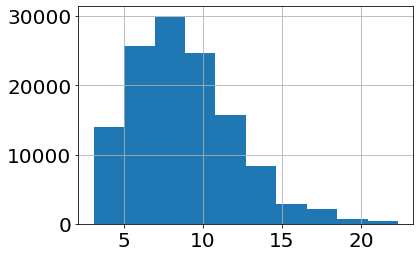

In [62]:
X_test_with_prob_xgb['expected_return'].hist()

The histogram above shows the distribution of expected rate of returns. We can see that a lot of them have an expected return of around 10-12%, which is higher than the average interest rate of all grade A loans of 7.08%. This means we can look at lower grade loans and find the ones that have a high probability of being paid off, and we can make more profit. 

In [63]:
X_test_with_prob_xgb

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,dti,fico_range_low,fico_range_high,inq_last_6mths,revol_util,annual_inc_joint,dti_joint,open_acc_6m,open_rv_12m,open_rv_24m,all_util,total_rev_hi_lim,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_actv_rev_tl,num_rev_tl_bal_gt_0,num_tl_op_past_12m,percent_bc_gt_75,tot_hi_cred_lim,total_bc_limit,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_revol_util,MORTGAGE,RENT,Not Verified,Verified,annual_inc,prob,expected_return
658844,24000.0,24000.0,24000.0,60.0,15.59,578.42,2,14,21.32,670.0,674.0,0.0,68.6,60000.0,21.32,1.0,3.0,3.0,74.0,17300.0,0.0,3.0,13728.0,1039.0,87.8,3.0,3.0,3.0,8.0,14.0,8.0,8.0,2.0,100.0,195452.0,8500.0,670.0,674.0,0.0,3.0,68.6,0,1,0,1,60000.0,0.694433,10.826204
146871,25000.0,25000.0,25000.0,60.0,10.99,543.44,1,8,10.30,705.0,709.0,0.0,59.4,60000.0,10.30,0.0,0.0,0.0,0.0,28200.0,0.0,3.0,32463.0,6236.0,72.9,14.0,7.0,2.0,29.0,7.0,2.0,2.0,1.0,66.7,278200.0,23000.0,705.0,709.0,0.0,2.0,59.4,1,0,1,0,60000.0,0.679260,7.465068
26644,28000.0,28000.0,27950.0,60.0,10.64,603.78,1,8,21.26,705.0,709.0,0.0,82.8,85000.0,21.26,0.0,0.0,0.0,0.0,47600.0,0.0,4.0,3182.0,2012.0,92.4,25.0,12.0,0.0,25.0,1.0,15.0,15.0,1.0,88.9,80513.0,26600.0,705.0,709.0,0.0,0.0,82.8,0,1,0,0,85000.0,0.713877,7.595651
115177,10000.0,10000.0,10000.0,36.0,8.18,314.20,1,5,3.20,685.0,689.0,0.0,39.3,95000.0,3.20,0.0,0.0,0.0,0.0,25500.0,0.0,1.0,40030.0,12259.0,43.0,19.0,19.0,3.0,19.0,19.0,2.0,2.0,0.0,33.3,378500.0,21500.0,685.0,689.0,0.0,3.0,39.3,0,0,0,0,95000.0,0.710151,5.809037
686205,10000.0,10000.0,10000.0,36.0,17.27,357.88,3,16,24.86,670.0,674.0,1.0,72.9,39000.0,24.86,2.0,4.0,4.0,77.0,9500.0,1.0,5.0,4343.0,2225.0,75.5,3.0,3.0,0.0,3.0,3.0,5.0,5.0,4.0,50.0,39392.0,9100.0,670.0,674.0,1.0,0.0,72.9,0,0,0,0,39000.0,0.710151,12.264311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213684,13000.0,13000.0,13000.0,60.0,18.55,334.02,4,21,14.23,660.0,664.0,1.0,95.4,97000.0,14.23,0.0,0.0,0.0,0.0,46500.0,0.0,3.0,47740.0,2126.0,95.4,14.0,7.0,2.0,14.0,3.0,4.0,4.0,1.0,100.0,298377.0,46500.0,660.0,664.0,1.0,2.0,95.4,1,0,1,0,97000.0,0.679260,12.600273
22882,2000.0,2000.0,2000.0,36.0,9.17,63.76,1,6,9.21,730.0,734.0,1.0,36.2,77272.0,9.21,0.0,0.0,0.0,0.0,22400.0,0.0,2.0,23214.0,9149.0,43.9,2.0,2.0,2.0,61.0,2.0,3.0,3.0,2.0,0.0,408798.0,16300.0,730.0,734.0,1.0,2.0,36.2,1,0,0,0,77272.0,0.721170,6.613133
234713,30000.0,30000.0,30000.0,60.0,17.86,759.52,3,19,9.62,705.0,709.0,1.0,58.8,96000.0,9.62,0.0,0.0,0.0,0.0,64800.0,0.0,5.0,24037.0,26623.0,58.9,11.0,11.0,4.0,11.0,0.0,7.0,7.0,1.0,25.0,277635.0,64700.0,705.0,709.0,1.0,4.0,58.8,1,0,0,1,96000.0,0.702015,12.537984
236115,20000.0,20000.0,20000.0,36.0,7.26,619.93,0,3,1.87,730.0,734.0,1.0,18.8,84000.0,1.87,0.0,0.0,0.0,0.0,24900.0,0.0,7.0,585.0,17221.0,18.0,6.0,6.0,0.0,6.0,6.0,5.0,5.0,3.0,0.0,24900.0,21000.0,730.0,734.0,1.0,0.0,18.8,0,0,0,1,84000.0,0.690563,5.013490


## Our Suggestions

Here are a few rows of our suggestion data which we randomly selected from the data we didn't use to train or test. Dr. D can take the process that we use on this sample data and apply it to his set of loans that he is choosing to invest in. 

In [66]:
to_suggest.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
354726,42504132,NaN,24000.0,24000.0,23950.0,36 months,10.99,785.62,B,B4,Teacher,10+ years,RENT,83000.0,Source Verified,Mar-2015,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,other,Other,764xx,TX,16.51,0.0,Mar-1990,725.0,729.0,1.0,49.0,NaN,17.0,0.0,19662.0,37.0,48.0,f,0.00,0.00,...,99880.0,58047.0,50400.0,46780.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
389714,39977574,NaN,12000.0,12000.0,12000.0,60 months,12.99,272.98,C,C2,Respiratory Therapist,10+ years,MORTGAGE,65686.0,Source Verified,Feb-2015,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,296xx,SC,14.76,0.0,Dec-1994,760.0,764.0,1.0,NaN,NaN,15.0,0.0,14145.0,18.7,29.0,w,0.00,0.00,...,313663.0,44347.0,51400.0,31613.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
361993,40962150,NaN,26000.0,26000.0,26000.0,60 months,17.86,658.26,D,D5,LeadCorporate Recruiter,5 years,RENT,95000.0,Source Verified,Feb-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,201xx,VA,13.10,1.0,Dec-1978,660.0,664.0,0.0,16.0,NaN,17.0,0.0,25938.0,77.9,23.0,w,0.00,0.00,...,44855.0,33240.0,8100.0,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
65230,65169780,NaN,14650.0,14650.0,14650.0,36 months,13.67,498.36,C,C4,RN,10+ years,MORTGAGE,95000.0,Verified,Nov-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,934xx,CA,16.50,3.0,Jul-1998,660.0,664.0,1.0,8.0,NaN,7.0,0.0,99077.0,77.6,20.0,w,0.00,0.00,...,488010.0,123161.0,2200.0,27132.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
139609,60515708,NaN,12800.0,12800.0,12800.0,60 months,12.69,289.22,C,C2,Registered Nurse,4 years,RENT,44000.0,Verified,Sep-2015,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,Credit card refinancing,243xx,VA,34.86,0.0,Dec-2004,660.0,664.0,0.0,79.0,39.0,15.0,2.0,7248.0,59.0,19.0,w,4717.33,4717.33,...,65769.0,51516.0,8150.0,53519.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


We go through the same data cleaning process below as we did above before creating our model. 

In [67]:
to_suggest_encoded = to_suggest
encoder = LabelEncoder()

#to_suggest_encoded['grade'] = encoder.fit_transform(to_suggest_encoded['grade'])
#to_suggest_encoded['sub_grade'] = encoder.fit_transform(to_suggest_encoded['sub_grade'])
home_ownership_ohc_suggest = pd.get_dummies(to_suggest_encoded['home_ownership'])
purpose_ohc_suggest = pd.get_dummies(to_suggest_encoded['purpose'])
verification_status_ohc_suggest = pd.get_dummies(to_suggest_encoded['verification_status'])
disbursement_method_ohc_suggest = pd.get_dummies(to_suggest_encoded['disbursement_method'])
application_type_ohc_suggest = pd.get_dummies(to_suggest_encoded['application_type'])
to_suggest_encoded = pd.concat([to_suggest_encoded, home_ownership_ohc_suggest, purpose_ohc_suggest, verification_status_ohc_suggest, disbursement_method_ohc_suggest, application_type_ohc_suggest], axis=1)
to_suggest_encoded = to_suggest_encoded.drop(columns=['home_ownership', 'purpose', 'verification_status', 'disbursement_method', 'application_type'])
#to_suggest_encoded['loan_status'] = to_suggest_encoded['loan_status'].astype('int')

int_rate = to_suggest_encoded['int_rate']
grades = to_suggest_encoded['grade']


to_suggest_important_col = to_suggest_encoded[X_train.columns]

to_suggest_important_col['term'] = to_suggest_important_col['term'].str.replace(r'\D+', '').astype(float)

to_suggest_important_col['dti'] = to_suggest_important_col['dti'].fillna(value=to_suggest_important_col['dti'].mean())
to_suggest_important_col['inq_last_6mths'] = to_suggest_important_col['inq_last_6mths'].fillna(0)
to_suggest_important_col['revol_util'] = to_suggest_important_col['revol_util'].fillna(0)
to_suggest_important_col['annual_inc_joint'] = to_suggest_important_col['annual_inc_joint'].fillna(to_suggest_important_col['annual_inc'])
to_suggest_important_col['dti_joint'] = to_suggest_important_col['dti_joint'].fillna(to_suggest_important_col['dti'])
to_suggest_important_col['open_acc_6m'] = to_suggest_important_col['open_acc_6m'].fillna(0)
to_suggest_important_col['open_rv_12m'] = to_suggest_important_col['open_rv_24m'].fillna(0)
to_suggest_important_col['open_rv_24m'] = to_suggest_important_col['open_rv_24m'].fillna(0)
to_suggest_important_col['all_util'] = to_suggest_important_col['all_util'].fillna(0)
to_suggest_important_col['total_rev_hi_lim'] = to_suggest_important_col['total_rev_hi_lim'].fillna(0)
to_suggest_important_col['inq_last_12m'] = to_suggest_important_col['inq_last_12m'].fillna(0)
to_suggest_important_col['acc_open_past_24mths'] = to_suggest_important_col['acc_open_past_24mths'].fillna(0)
to_suggest_important_col['avg_cur_bal'] = to_suggest_important_col['avg_cur_bal'].fillna(0)
to_suggest_important_col['bc_open_to_buy'] = to_suggest_important_col['bc_open_to_buy'].fillna(0)
to_suggest_important_col['bc_util'] = to_suggest_important_col['bc_util'].fillna(0)
to_suggest_important_col['mo_sin_rcnt_rev_tl_op'] = to_suggest_important_col['mo_sin_rcnt_rev_tl_op'].fillna(to_suggest_important_col['mo_sin_rcnt_rev_tl_op'].max())
to_suggest_important_col['mo_sin_rcnt_tl'] = to_suggest_important_col['mo_sin_rcnt_tl'].fillna(to_suggest_important_col['mo_sin_rcnt_tl'].max())
to_suggest_important_col['mort_acc'] = to_suggest_important_col['mort_acc'].fillna(0)
to_suggest_important_col['mths_since_recent_bc'] = to_suggest_important_col['mths_since_recent_bc'].fillna(to_suggest_important_col['mths_since_recent_bc'].max())
to_suggest_important_col['mths_since_recent_inq'] = to_suggest_important_col['mths_since_recent_inq'].fillna(to_suggest_important_col['mths_since_recent_inq'].max())
to_suggest_important_col['num_actv_rev_tl'] = to_suggest_important_col['num_actv_rev_tl'].fillna(0)
to_suggest_important_col['num_rev_tl_bal_gt_0'] = to_suggest_important_col['num_rev_tl_bal_gt_0'].fillna(0)
to_suggest_important_col['num_tl_op_past_12m'] = to_suggest_important_col['num_tl_op_past_12m'].fillna(0)
to_suggest_important_col['percent_bc_gt_75'] = to_suggest_important_col['percent_bc_gt_75'].fillna(0)
to_suggest_important_col['tot_hi_cred_lim'] = to_suggest_important_col['tot_hi_cred_lim'].fillna(0)
to_suggest_important_col['total_bc_limit'] = to_suggest_important_col['total_bc_limit'].fillna(0)
to_suggest_important_col['sec_app_fico_range_low'] = to_suggest_important_col['sec_app_fico_range_low'].fillna(to_suggest_important_col['fico_range_low'])
to_suggest_important_col['sec_app_fico_range_high'] = to_suggest_important_col['sec_app_fico_range_high'].fillna(to_suggest_important_col['fico_range_high'])
to_suggest_important_col['sec_app_inq_last_6mths'] = to_suggest_important_col['sec_app_inq_last_6mths'].fillna(to_suggest_important_col['inq_last_6mths'])
to_suggest_important_col['sec_app_mort_acc'] = to_suggest_important_col['sec_app_mort_acc'].fillna(to_suggest_important_col['mort_acc'])
to_suggest_important_col['sec_app_revol_util'] = to_suggest_important_col['sec_app_revol_util'].fillna(to_suggest_important_col['revol_util'])
to_suggest_important_col['annual_inc'] = to_suggest_important_col['annual_inc'].fillna(0)
to_suggest_important_col['annual_inc_joint'] = to_suggest_important_col['annual_inc_joint'].fillna(to_suggest_important_col['annual_inc'])



We apply the tuned XGBoost model to this new set of mock data and predict the expected return. 

In [68]:
to_suggest_prob = xgb_tuned.predict_proba(to_suggest_important_col)
to_suggest_df = to_suggest_important_col
to_suggest_df['prob'] = [item[0] for item in to_suggest_prob]
to_suggest_df['int_rate'] = int_rate
to_suggest_df['grade'] = grades
to_suggest_df['expected_return'] = to_suggest_df['prob'] * to_suggest_df['int_rate']

In [69]:
to_suggest_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,dti,fico_range_low,fico_range_high,inq_last_6mths,revol_util,annual_inc_joint,dti_joint,open_acc_6m,open_rv_12m,open_rv_24m,all_util,total_rev_hi_lim,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_actv_rev_tl,num_rev_tl_bal_gt_0,num_tl_op_past_12m,percent_bc_gt_75,tot_hi_cred_lim,total_bc_limit,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_revol_util,MORTGAGE,RENT,Not Verified,Verified,annual_inc,prob,int_rate,grade,expected_return
354726,24000.0,24000.0,23950.0,36.0,16.51,725.0,729.0,1.0,37.0,83000.0,16.51,0.0,0.0,0.0,0.0,53100.0,0.0,11.0,4146.0,30738.0,39.0,1.0,1.0,0.0,1.0,1.0,8.0,8.0,5.0,20.0,99880.0,50400.0,725.0,729.0,1.0,0.0,37.0,0,1,0,0,83000.0,0.814149,10.99,B,8.947501
389714,12000.0,12000.0,12000.0,60.0,14.76,760.0,764.0,1.0,18.7,65686.0,14.76,0.0,0.0,0.0,0.0,75500.0,0.0,9.0,18942.0,42169.0,18.0,3.0,2.0,3.0,42.0,1.0,5.0,5.0,4.0,0.0,313663.0,51400.0,760.0,764.0,1.0,3.0,18.7,1,0,0,0,65686.0,0.892206,12.99,C,11.589750
361993,26000.0,26000.0,26000.0,60.0,13.10,660.0,664.0,0.0,77.9,95000.0,13.10,0.0,0.0,0.0,0.0,33300.0,0.0,4.0,1955.0,3037.0,62.5,3.0,3.0,0.0,14.0,21.0,10.0,10.0,3.0,33.3,44855.0,8100.0,660.0,664.0,0.0,0.0,77.9,0,1,0,0,95000.0,0.531604,17.86,D,9.494439
65230,14650.0,14650.0,14650.0,36.0,16.50,660.0,664.0,1.0,77.6,95000.0,16.50,0.0,0.0,0.0,0.0,104600.0,0.0,2.0,57166.0,169.0,92.3,96.0,4.0,2.0,112.0,4.0,4.0,4.0,1.0,100.0,488010.0,2200.0,660.0,664.0,1.0,2.0,77.6,1,0,0,1,95000.0,0.887499,13.67,C,12.132117
139609,12800.0,12800.0,12800.0,60.0,34.86,660.0,664.0,0.0,59.0,44000.0,34.86,0.0,0.0,0.0,0.0,12250.0,0.0,9.0,3962.0,1164.0,76.0,4.0,4.0,0.0,4.0,18.0,10.0,8.0,7.0,42.9,65769.0,8150.0,660.0,664.0,0.0,0.0,59.0,0,1,0,1,44000.0,0.316085,12.69,C,4.011118


Here we find the average probabilty (among other statistics) that a loan will be fully payed back

In [70]:
grades_median = to_suggest_df.groupby('grade').median()
grades_mean = to_suggest_df.groupby('grade').mean()
grades_std = to_suggest_df.groupby('grade').agg(np.std)

grades_mean_dict = grades_mean['prob'].to_dict()

We found that the average A loan has a 89% chance of being paid back. Now, we find all loans that were given a grade below A but have a probability of 89% or greater of being paid back.

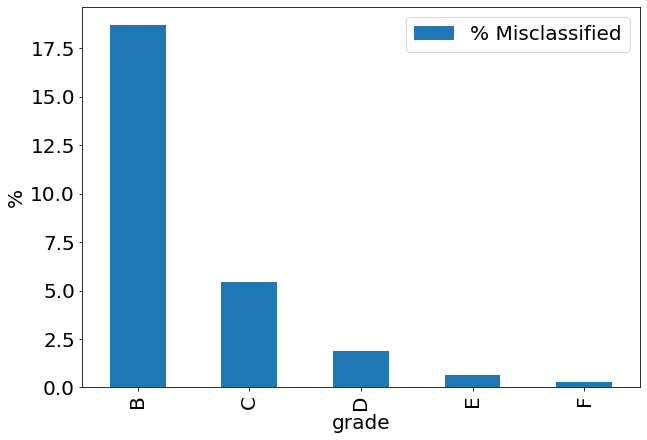

In [71]:
to_suggest_df = to_suggest_df[['loan_amnt','grade','prob','int_rate','expected_return']]


# Filter out all loans which were given an A grade
data_no_A = to_suggest_df[to_suggest_df['grade'] != 'A']

# Functions finds all loans which were misclassified as A or below
def findMisClassified(data_no_A, grade, perc=0.89):

    filtered = data_no_A[data_no_A['grade'] == grade]

    filtered.loc[filtered['prob'] > perc, 'misclassified'] = True
    return filtered.fillna(value=False)

misclassified_dict = {}

# Plot a bar graph of the percentage of misclassified loans by each grade
for key in grades_mean_dict.keys():
    if key == 'A': 
        continue
    try: 
        misclassified_dict[key] = findMisClassified(data_no_A, key)['misclassified'].value_counts(normalize=True)[1] * 100
    except: 
        continue
    
misclassified_df = pd.DataFrame(list(misclassified_dict.items()), columns = ['grade', '% Misclassified'])
misclassified_df = misclassified_df.set_index('grade')
misclassified_df.plot(kind='bar', figsize=(10,7), ylabel='%')

In [72]:
%%html
<script type='text/javascript' src='https://prod-useast-b.online.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1440px; height: 767px;'><object class='tableauViz' width='1440' height='767' style='display:none;'><param name='host_url' value='https%3A%2F%2Fprod-useast-b.online.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='&#47;t&#47;jain18451' /><param name='name' value='MisclassifiedLoans2&#47;MeanofLoans' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='showAppBanner' value='false' /></object></div>

We then used Tableau to break down the misclassified loans by their initial grade. Here we compared the expected return, quantity of misclassified loans per grade, the sum of the loans in any particular grade and the total expected profit generated given our expected return. 

In [73]:
%%html
<script type='text/javascript' src='https://prod-useast-b.online.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1440px; height: 767px;'><object class='tableauViz' width='1440' height='767' style='display:none;'><param name='host_url' value='https%3A%2F%2Fprod-useast-b.online.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='&#47;t&#47;jain18451' /><param name='name' value='MisclassifiedLoans2&#47;LoansMeanofAs' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='showAppBanner' value='false' /></object></div>

As can be seen, "B" grade loans are most commonly misclassified and have the opportunity to earn up to $8.8M in expected profit based on our expected return percentage. This indicates that there exists "B" grade loans and other grades have siginficant upside that are not neccesarily actually more risky than the "A" grade loans. This can offer a unique investment opportunity.

Based on this data, our investment strategy is to invest in loans rated B-G that have a probability of being fully paid off of greater than 89% based on our algorithm. We noticed that there were loans that were misclassfiied that had significant interest rates of up to 26%, that could still be classfied as "A" grade loans by our approach. By first investing in the "G" grade loans that could be reclassified as "A" grade loans, and then once exhausted, investing in "F" grade loans that could be reclassified as "A" grade loans and so on, we can maximise the principal investment amount by investing in loans that have the highest interest with risk akin to low interest rate loans.


In [74]:
%%html
<script type='text/javascript' src='https://prod-useast-b.online.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1440px; height: 767px;'><object class='tableauViz' width='1440' height='767' style='display:none;'><param name='host_url' value='https%3A%2F%2Fprod-useast-b.online.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='&#47;t&#47;jain18451' /><param name='name' value='ProjectedReturns&#47;Sheet1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='showAppBanner' value='false' /></object></div>


Given $10,000,000 invested into loans on LendingClub that we reclassify as “A” grade loans, we would return a 14.85% rate on principal investment. Our strategy more than doubles the average “A” loan grade expected return. As a result of our reclassification model, this enables us to still invest in and benefit from LendingClub’s riskier loans, but that still have a high potential to be paid off in full.


### Future Improvements

1. Account for reinvestment based on loan term
2. Look at loans that were paid off early
3. Look at earning some money from defaulted loans
4. Consider misclassified B loans in addition to A loans that might give a better return for slightly more risk
